<a href="https://colab.research.google.com/github/BuskovaH/mars-probe-simulation/blob/main/mars_probe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Orbit simulation
There's loads of simulations for Kepler's laws on the web: unfortunately none of them suits my needs - to let highschool students see and understand the "guts" of the simulation - it's one thing to see the simulation (which is a need that can be easily fulfilled by stuff already out there, like [this beautiful simulation from University of Colorado](https://phet.colorado.edu/sims/html/keplers-laws/latest/keplers-laws_all.html), it's a different one all together to see that the simulations are a result of math that the target group already understands.

The first step in any Python program is to tell it which external libraries to include: `numpy` is a library which contains math beyond +, -, *, / and modulo. the `plt` part of `matplotlib` is the most commonly used library for making graphs. `time` was added because I was feeling fancy and wanted to measure how long each part took.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import time

The following block of code contains mathematical constants which we need: feel free to substitute M and m for other systems: Sun and Earth, Earth and a satelite, or Earth and the Moon for example. (I must warn you about the last system: the Moon is far too heavy for our simulation, which assumes that the main body is a lot heavier than the lighter one.)

A fun game that we made up is that you roll a die, and then plug the result in the `x_0` variable (the distance from origin), multiplied by radius (rerolling for 1, because then the probe would lie on the planet from the beginning). Teams of students can then compete in either making their orbit the roundest possible by changing up velocities, or landing the probe on the planet at the gentlest angle.

In [27]:
#Don't forget to execute this block after making any changes to it!

units = {"length":"m", "mass":"kg", "time":"s"}
M = 6.4171*10**23 #mass of Mars in kg
m = 100 #ballpark of the mass of our probe
G = 6.67430*10**(-11) #gravitational constant in km^3/kg*s^2
Δt = 30 #s
timesteps = 100000
radius = 33895000 # radius of Mars in meters
atm_height = 130000 # height of atmosphere in meters

x_0 = 2*radius # starting position of the satellite in meters: pick whatever, roll a die.
y_0 = 0
v_x0 = 0  # starting speed in m/s
v_y0 = 700 # to simplify our problem, we have speed perpendicular to the position vector
  # thanks to that simplification, we also know that the beginning of the path
  # of the satellite is one of the pointy ends of an ellipse

# The math of the program

## Explanation

(Feel free to skip ahead and then return to it later, I won't judge.)

To make code easier on the eyes, we usually clean up blocks that are in charge of a task into a single function or object.

Technically the only important function here is `update_phasespace`. The idea of the algorithm (called Euler's algorithm, because it's one of the many things Euler came with first) is that instead of figuring out the whole path at once, we could do what nature does: at every single point of its path, the particle decides what to do next based on its position to things that attract or repel it.

Computers cannot calculate the whole smooth path, but if we cut it up into pieces that are small enough, nobody will notice that it's not infinitely smooth.

So let's say we're looking at our simulation at time $t_1$. The satellite has some velocity. By now, we should know that velocity is a vector - it has a direction and a size. The direction is what makes velocity different from speed. Fortunately, that means that we can separate the velocity in our system into two parts: let's call them $v_x$ and $v_y$, separating the velocity in the two directions that are parallel to the axes x and y. Likewise, we can describe where exactly a particle in a system is, by noting its $x$ and $y$ coordinates.

Now let's see what happens in time $t_2$, which is imperceptibly close to $t_1$. The particle "looks what changed" since it was at $t_1$, and adjusts its movements to the new environment it found itself in. In the most basic form, the Euler's algorithm looks like this:


```
while the simulation runs:
  check the acceleration
  modify the velocity
  modify the position
  (you should probably note those somewhere)
```

How do we check the acceleration? We combine Newton's first law:
\begin{equation}
F = ma
\end{equation}
and the law of gravity:
\begin{equation}
F = \frac{GMm}{r^2}
\end{equation}

To simplify our problem drastically, we'll pretend that the larger mass isn't moving at all, and it is at the center of the universe, or at the coordinates $[0,0]$. After all, we can put the center wherever we want, so why not there? That also means that the vector $\mathbf{r}$, which connects the centers of those two objects, becomes just the direction of where the satellite is. Notice one unfortunate thing: the equation above doesn't contain a single vector: it doesn't tell us where the acceleration will be pointing, which is a problem if we need to separate the x and y components. We cannot solve it by simply keeping $x^2$ or $y^2$ as the denominator and tossing the other one - it's important for the force how far the two bodies are, not how far they seem when you stand on the x- or y-axis and squint. We will employ an important technique known as cheating. Instead of trying to tease out the size of the x-coordinate part of the equation, we can multiply it by how much of the coordinate is there. It can be shown, that for any vector $\mathbf{v}$ (where $|\mathbf{v}|$ is the size of the vector, regardless of its original direction),

\begin{equation}
\frac{\mathbf{v}}{|\mathbf{v}|}
\end{equation}

is a vector that's exactly 1 unit long (regardless of the units), and points in the direction of the original vector. The law of gravity, accomodating for direction, then becomes

\begin{equation}
\mathbf{F} = -\frac{GMm}{r^2}\frac{\mathbf{r}}{|r|}
\end{equation}

The units stay the same, but now the force points in a direction, hopefully the correct one. If we skipped the minus, the force would be a repulsive one. Let's not go into details here; try it on paper if you want.

The nice thing about programming is that you don't have to create one frankenequation, you can just do small steps at a time - that's why the 'update_acceleration' and 'update_phasespace' functions can calculate first the vectors in x, then in y (although Python could certainly do both for us at once, and faster than doing it separately, it would make the code scarier). In each step, we're therefore calculating the force by knowing where the particles are, then calculating the acceleration by taking it as $a = F/m$, and then the velocity: this is the point where we have to remember our SUVAT equations, and that $v = v_0 + at$ and $x = x_0 + vt$.

Because we won't need the original positions and velocities, we can overwrite them with the new in the working memory of the computer, which creates the line $v_x = v_x + a_x\Delta t$ and its like. Perfectly reasonable in the world of programming, but rather a confusing term when taken as a math equation.

I had some inner debate whether to include drag in our calculations. Drag depends on speed (not velocity) of the object it's applied to. Because I was lazy and the atmosphere of Mars is thin anyway, I adopted a model of a hard shell that turns on at the border of atmosphere. It's a terrible model, and if you're planning on modifying your copy for the Earth, you might consider replacing it for a more reasonable one.

`crashcheck` function stops the simulation when your probe hits the surface of the planet. Without it, the probe would be stuck in orbit around the center of mass forever.

`plot` draws things. It's a very ugly piece of code, and you can even see that I prompted Gemini AI to make it for me. The colour of the trail starts at dark blue and goes to yellow at the end of the simulation. Feel free to adjust it to a colour scheme of your choice.

## Codeblock

In [28]:
def update_acceleration(frame):
    x, y, v_x, v_y = frame
    r2 = x**2 + y**2
    r = np.sqrt(r2)
    v2 = v_x**2 + v_y**2
    v = np.sqrt(v2)
    gravF_x = -((G*M*m)/(r2))*(x/r)
    gravF_y = -((G*M*m)/(r2))*(y/r)
    dragF = 0.5*rho(r2)*v2*0.42*4
    F_x = gravF_x + dragF*v_x/v
    F_y = gravF_y + dragF*v_y/v
    a_x = F_x/m
    a_y = F_y/m
    return [a_x, a_y]


def update_phasespace(frame):
    x, y, v_x, v_y = frame
    a_x, a_y = update_acceleration(frame)
    v_x = v_x + a_x*Δt
    v_y = v_y + a_y*Δt
    x = x + v_x*Δt
    y = y + v_y*Δt
    return [x, y, v_x, v_y]


def rho(r2): #this is stupid and I'm ashamed, the error is not huge for Mars tho.
    pressure = 610 #Martian at ground level
    atmosphere_height = 130000 #m
    grav_acceleration = 3.72076 #m/s-2
    if r2 > radius+atm_height:
        return 0
    else:
        return pressure/(atmosphere_height*grav_acceleration)


def crashcheck(frame):
    x, y, v_x, v_y = frame
    r2 = x**2 + y**2
    if r2 < radius**2:
        print("Probe landed with speed " + str(np.sqrt(frame[2]**2 + frame[3]**2)))
        print("Angle of entry is " + str(np.arctan2(v_y, v_x)*180/np.pi))
        return True
    else:
        return False


def plot(frames):
    lim = np.max(np.abs(frames[:, 0:1]))
    # prompt: from x and y make a scatter plot that progressively colours each point.
    fig, ax = plt.subplots()
    sc = ax.scatter(frames[:, 0], frames[:, 1], c=np.arange(len(frames[:,0])), s=5, cmap='viridis')
    center = ax.scatter(0, 0, c='red', s=10)
    circle = ax.add_patch(plt.Circle((0, 0), radius, color='red', fill=False))
    ax.set_xlabel(f"x [{units['length']}]")
    ax.set_ylabel(f"y [{units['length']}]")
    ax.set_ylim(-lim, lim)
    ax.set_xlim(-lim, lim)
    ax.set_title("Simulation of the path of m around M")
    fig.colorbar(sc, label="Timestep")
    plt.show()


def s_to_dhms(seconds):
    days = int(seconds/86400)
    hours = int((seconds-(days*86400))/3600)
    minutes = int((seconds-(days*86400)-(hours*3600))/60)
    seconds = int(seconds-(days*86400)-(hours*3600)-(minutes*60))
    return days, hours, minutes, seconds

# End of the math part and the beginning of the program

## Explanation

First, it notes the time it started.
Next, it stores the initial position and speed in a form the rest of the program understands.
`for something in range(whatever)` line makes the indented stuff under it repeat a number of times that's in the brackets. It has to count the number of times it's doing the cycle: it's storing those in a variable I called `i`, and incrementing it every time it repeats the cycle.

In the cycle itself, it takes the snapshot (here called `frame`) it was given the last time, and overwrites it with new positions and velocities, an increment of time later (the increment of time is denoted in the second codeblock by $\Delta t$). Then we're sticking the new calculated value at the end of the series of snapshots we have, like how an analog camera stores the scene by taking separate pictures in quick succession. Each cycle it also checks if the probe isn't already at the surface of the planet - if it is, the simulation ends.

the line `frames = np.array(frames)` is just a change of storage. It can be avoided, but it makes the following code more compact: it already looks horrible, and it could look worse.

Storing the frames as an array right away was also possible, but given how Python stores lists (which `frames` was originally) and arrays, this is more efficient.

`mid = time.time()` and `end = time.time()` do the exact same thing, noting the time when the computer encountered that line of code. I wanted to see how much time it took for the calculation itself, and how long it took to make the information digestible for humans.

## Codeblock

Simulated time 34 days 17 hours 20 minutes 30 seconds
Average velocity 0.9 km/s
Simulation took 0.839 seconds to process, with 0.006 second overhead.


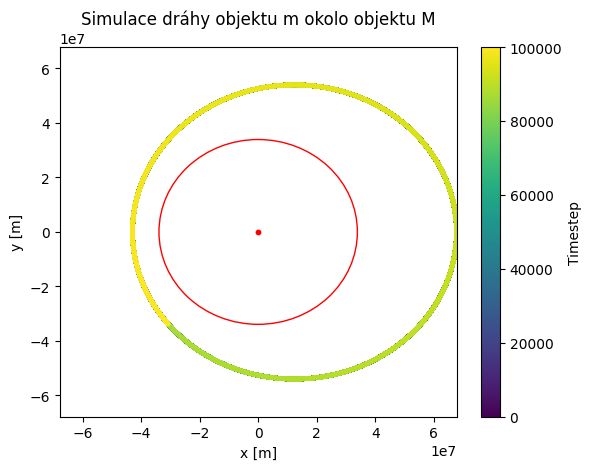

Plotting took 2.066 seconds


In [25]:
# If you're running the program for the first time in a session,
# you have to run all the blocks first.
# After that, you can choose to run only the ones you made changes to.

start = time.time()

frame = [x_0, y_0, v_x0, v_y0]
frames = [frame]

for i in range(timesteps):
    frame = update_phasespace(frame)
    frames.append(frame)
    if crashcheck(frame) == True:
      break

frames = np.array(frames)

mid = time.time()

days, hours, minutes, seconds = s_to_dhms(len(frames[:,0])*Δt)
print("Simulated time", str(days), "days", str(hours), "hours", str(minutes), "minutes", str(seconds), "seconds")
print("Average velocity", np.round(np.mean(np.sqrt(frames[:, 2]**2 + frames[:, 3]**2))/1000, 1), "km/s")

end = time.time()
print("Simulation took", np.round(mid-start, 3), "seconds to process, with", np.round(end-mid, 3), "second overhead.")

plot(frames)

plot_time = time.time()
print("Plotting took", np.round(plot_time-end, 3), "seconds")